# Interpretable conditional model

## import

In [1]:
import logging
import os
from functools import partial
from shutil import which

import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd

from mctm.data.sklearn_datasets import get_dataset
from mctm.models import DensityRegressionModel, HybridDenistyRegressionModel
from mctm.utils import str2bool
from mctm.utils.pipeline import pipeline, prepare_pipeline
from mctm.utils.tensorflow import fit_distribution, set_seed
from mctm.utils.visualisation import (
    get_figsize,
    plot_2d_data,
    plot_flow,
    plot_samples,
    setup_latex,
)

2023-10-06 14:54:33.257356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 14:54:33.257377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

## Params

In [81]:

seed = 1
distribution = "bernstein_flow"
dataset_kwds = {"n_samples": 2000, "scale": True}
distribution_kwds = {
    "order": 10,
    "low": -4,
    "high": 4,
    "eps": 0.001,
    "smooth_bounds": True,
    "allow_flexible_bounds": True,
    "shift": False,
    "scale": False,
    "clip_to_bernstein_domain": False,
    # "base_distribution_kwds": {"distribution_type": "uniform", "low": 0, "high": 1},
}
parameter_kwds = {"dtype": "float", "polynomial_order": 1, "conditional_event_dims": 1}
fit_kwds = {
    "epochs": 2000,
    "validation_split": 0.1,
    "batch_size": 128,
    "learning_rate": 0.02,
    #tf.keras.optimizers.schedules.CosineDecayRestarts(
    #    initial_learning_rate=0.01, first_decay_steps=20
    #),
    "lr_patience": 50,
    "reduce_lr_on_plateau": False,
    "early_stopping": True,
    "verbose": True,
    "monitor": "val_loss",
}

In [82]:
model_kwds = dict(
    distribution=distribution,
    distribution_kwds=distribution_kwds,
    parameter_kwds=parameter_kwds,
)

get_model = DensityRegressionModel

preprocess_dataset = lambda data, model: {
    "x": tf.convert_to_tensor(data[0], dtype=model.dtype),
    "y": tf.convert_to_tensor(data[1], dtype=model.dtype),
}
results_path = "./results/" + distribution

## Function

## Fit model

### set seed

In [83]:
set_seed(seed)

### Load Data

In [84]:
def gen_data(n_samples, scale):
    t = np.random.uniform(0, 1, n_samples).astype(np.float32)

    t1 = t
    y1 = 1.0 * t1
    y1 += np.random.normal(0, 0.05 * np.abs(t1))

    t2 = t
    y2 = -0.2 * t2
    y2 += np.random.normal(0, 0.2 * np.abs(t2))

    t = np.concatenate([t1, t2])
    y = np.concatenate([y1, y2])

    if scale:
        y_min = y.min()
        y_max = y.max()
        y -= y_min
        y /= y_max - y_min
    return t[..., np.newaxis], y[..., np.newaxis]

In [85]:
set_seed(seed)
dims = 1
data = gen_data(**dataset_kwds)
data

(array([[4.17021990e-01],
        [7.20324516e-01],
        [1.14374816e-04],
        ...,
        [8.28732848e-01],
        [3.09979599e-02],
        [9.46728289e-01]], dtype=float32),
 array([[0.6441309 ],
        [0.7987879 ],
        [0.41030592],
        ...,
        [0.28936213],
        [0.4086016 ],
        [0.33704627]], dtype=float32))

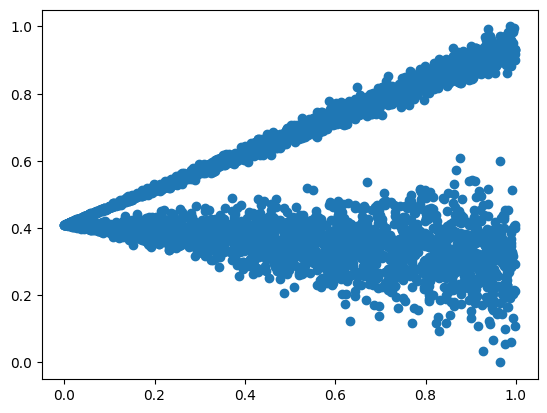

In [86]:
plt.scatter(*data)

In [87]:
# data, dims = get_dataset(**dataset_kwds)
# fig = plot_2d_data(*data)

### Init Model

In [88]:
from mctm.parameters import get_parameter_vector_lambda

In [89]:
def get_polynomial_parameter_lambda(
    parameter_shape, polynomial_order, conditional_event_dims, dtype
):
    parameter_shape = [
        1,
        conditional_event_dims,
        polynomial_order + 1,
    ] + parameter_shape
    _, parameter_vector = get_parameter_vector_lambda(
        parameters_shape=parameter_shape, dtype=dtype
    )

    def parameter_lambda(conditional_input=None, **kwds):
        xx = tf.stack(
            [conditional_input**i for i in range(0, polynomial_order + 1)], -1
        )
        yy = xx[..., None, None] * parameter_vector
        return tf.reduce_sum(yy, axis=[1, 2])

    return parameter_lambda, parameter_vector

In [90]:
model = DensityRegressionModel(
    dims=dims, get_parameter_lambda_fn=get_polynomial_parameter_lambda, **model_kwds
)

### execute training

In [91]:
preprocessed = preprocess_dataset(data, model)

In [92]:
def nll_loss(y, dist):
    return -dist.log_prob(y)

In [93]:
hist = fit_distribution(
    model=model,
    seed=seed,
    results_path=results_path,
    loss=nll_loss,
    **preprocessed,
    **fit_kwds,
)

Epoch 1/2000
24/29 [=======================>......] - ETA: 0s - loss: 0.7071 
Epoch 1: val_loss did not improve from -0.65525

Epoch 1: val_loss did not improve from -0.65525

Epoch 1: val_loss did not improve from -0.65525

Epoch 1: val_loss improved from inf to 0.25696, saving model to ./results/bernstein_flow/mcp/weights
29/29 [==============================] - 2s 15ms/step - loss: 0.6299 - val_loss: 0.2570
Epoch 2/2000
22/29 [=====================>........] - ETA: 0s - loss: -0.0494
Epoch 2: val_loss did not improve from -0.65525

Epoch 2: val_loss did not improve from -0.65525

Epoch 2: val_loss did not improve from -0.65525

Epoch 2: val_loss improved from 0.25696 to 0.00043, saving model to ./results/bernstein_flow/mcp/weights
29/29 [==============================] - 0s 4ms/step - loss: -0.0872 - val_loss: 4.2767e-04
Epoch 3/2000
23/29 [======================>.......] - ETA: 0s - loss: -0.2389
Epoch 3: val_loss did not improve from -0.65525

Epoch 3: val_loss did not improve fro

<Axes: >

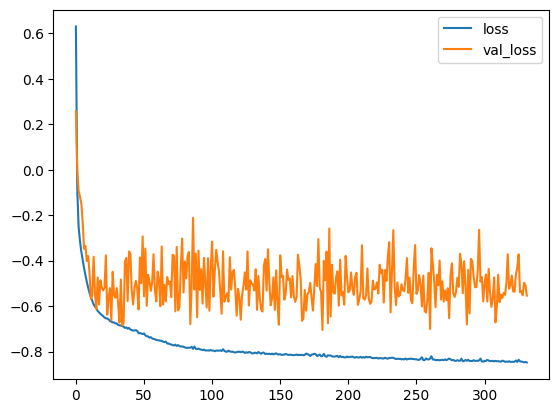

In [94]:
import pandas as pd

pd.DataFrame(hist.history).plot()

### Results

In [95]:
x, y = preprocessed.values()
dist = model(x)
dist

<tfp.distributions._TransformedDistribution 'invert_chain_of_bpolySampleNormal' batch_shape=[4000] event_shape=[1] dtype=float32>

In [96]:
samples = dist.sample(seed=1).numpy()
samples.shape

(4000, 1)

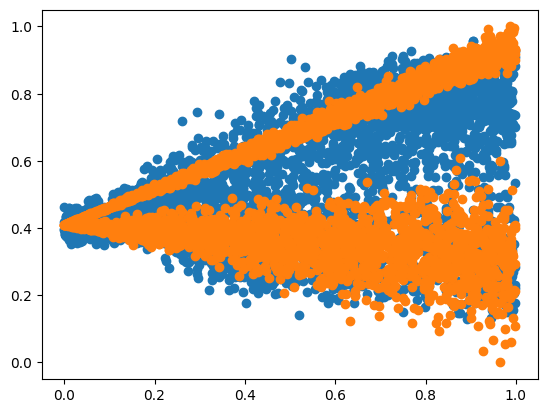

In [97]:
plt.scatter(x, samples.flatten())
plt.scatter(*data)

In [98]:
model(tf.ones_like(x))

<tfp.distributions._TransformedDistribution 'invert_chain_of_bpolySampleNormal' batch_shape=[4000] event_shape=[1] dtype=float32>

In [99]:
model.trainable_parameters

<tf.Variable 'Variable:0' shape=(1, 1, 2, 1, 10) dtype=float32, numpy=
array([[[[[  8.078703  ,   8.994402  ,  -2.0182269 ,  -1.3195286 ,
             2.6119282 ,  -5.4583287 ,  -4.8349943 ,   0.46402973,
            -1.074972  ,  -2.4520843 ]],

         [[ -7.648672  , -12.245733  ,   2.4639099 ,  -1.5389798 ,
           -18.835522  ,  -5.409193  ,  -4.5991483 ,  -7.26614   ,
            -4.02232   ,   2.8598418 ]]]]], dtype=float32)>

In [100]:
from bernstein_flow.activations import get_thetas_constrain_fn

tcf = get_thetas_constrain_fn(
    low=distribution_kwds["low"],
    high=distribution_kwds["high"],
    smooth_bounds=distribution_kwds["smooth_bounds"],
    allow_flexible_bounds=distribution_kwds["allow_flexible_bounds"],
    eps=distribution_kwds["eps"],
)

In [101]:
t = np.linspace(0.0, 1.0, 200, dtype="float32")
pv_u = model.distribution_parameters_lambda(t[..., None]).numpy().squeeze()
pv = tcf(pv_u)

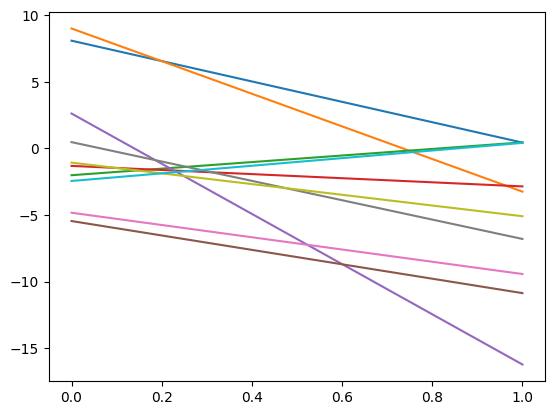

In [102]:
fig = plt.plot(t, pv_u)

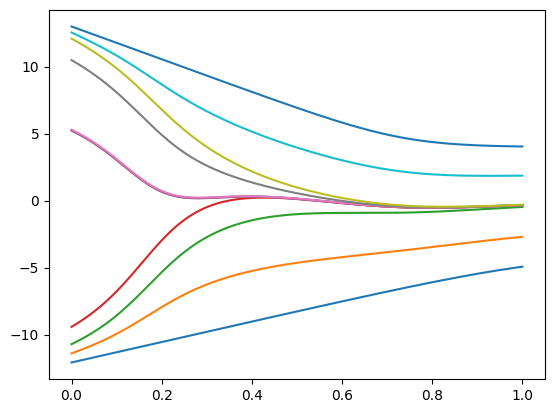

In [103]:
fig = plt.plot(t, pv)